In [2]:
# Load libraries

import numpy as np
import scipy
from scipy.ndimage import convolve1d
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import os
import sys

import librosa
import librosa.display

In [3]:
# Define path to audio file

directory_path = '/home/daansan/David/MusicDetection/data/'
filename = 'voice.wav'

filepath = os.path.join(directory_path, filename)

In [4]:
def silences(data, hop_length=512):
    """Detects where silences are and it returns a numpy array with 
    their time location in the audio signal

    Parameters
    ----------
    data : numpy array
        The audio signal imported with scipy.io.wavfile
    hop_length : integer
        Hop length for the STFT (default is 512)

    Returns
    -------
    numpy array
        A numpy array with values False if silence and True if sound
        of the same size as the original signal array
    """
    silences = [0]
    
    for i in range(0, data.shape[0], hop_length):
        x = data[i:i+hop_length].max()
        silences.append(x * np.abs(x)>0.0001)
        
    return np.array(silences)


In [34]:
def MusicDetection(filepath):
    """Detects music in an audio file.

    Parameters
    ----------
    filepath : string
        Path to the audio file to analyse

    Returns
    -------
    time
        A numpy array with values False if silence and True if sound
        of the same size as the original signal array
    
    """
    
    # Load the audio
    sr, data = read(filepath)
    
    # Insulate one track and normalize
    x = data[:, 1].astype(np.float32)
    x = x / np.abs(x).max() / 2
    
    # Get chromagram
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
    
    # Clean fragments with silences
    silences_location = silences(x, hop_length)
    silences_locationsilences_location = silences_location[:, np.newaxis]
    chroma_no_silence = chromagram * silences_location[:chromagram.shape[1]].T
    
    # Filter chroma values by window
    window = 30 # ~0.4s
    filter_value = 10
    # keep only maximum amplitudes
    chroma_filter = np.ceil(chroma_no_silence * (chroma_no_silence >= 1))
    # get duration of the audio track
    length = x.size/sr 
    # define time array 
    time = np.arange(chroma_no_silence.shape[1]) / chroma_no_silence.shape[1] * length
    for i in range(0, chroma_filter.shape[1], window):
        # create windows-sized sections of the chroma
        section = chroma_filter[:, i:i+window]
        # sum chroma values for the current section
        sum_section = section.sum(axis=1)
        # filter results by optimised value and apply to section
        filter = sum_section > filter_value
        filter = filter[:, np.newaxis]
        chroma_filter[:, i:i+window] = section * filter   

    # Convolve to detect constant patterns
    integration_time = 10
    hammer_window = np.ones(integration_time)
    convolved_chromagram = convolve1d(chroma_filter, hammer_window) / \
    convolve1d(chroma_filter, hammer_window).mean() > 0.6 
    convolved_chromagram = np.ceil(convolved_chromagram)
    
    # Detect isolated music/voice incidences in the next 3 seconds
    signal = convolved_chromagram.max(axis=0)
    window = 260
    signal_filtered = []
    for i in range(signal.shape[0]):
        signal_filtered.append(signal[i:i+window].mean() > 0.55)

    # Final outcome with a time delay to compensate previous windows filter
    delay = 1.5
    time = time+delay
    time[0] = 0
    time[time > length] = length
    music = signal_filtered
    
    # Plot outcome
    fig, ax = plt.subplots(figsize=(20,5));
    plt.plot(time, music)
    plt.xticks(np.arange(0, length, 1))
    plt.show()  
    
    return time, music

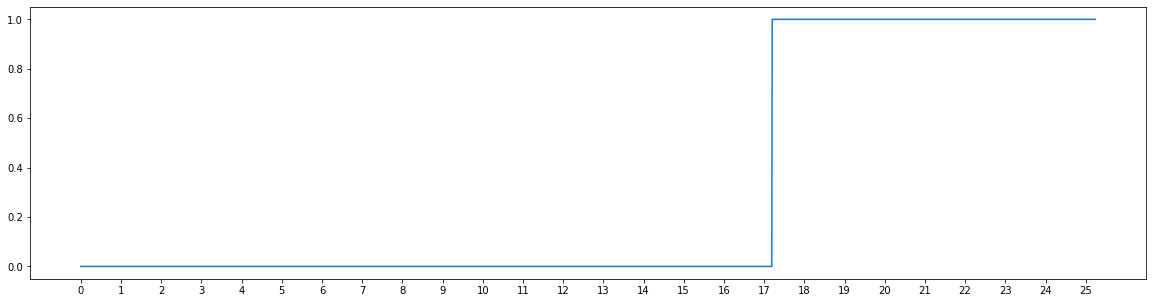

In [35]:
time, music = MusicDetection(filepath)